# Analyse de sentiments sur des avis clients

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install -U spacy
!python3 -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 3.0 MB/s eta 0:00:01    |██▌                             | 1.1 MB 2.8 MB/s eta 0:00:05


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
#Chargement et préparation des données 
df_yelp = pd.read_table('yelp_labelled.txt')
df_imdb = pd.read_table('imdb_labelled.txt')
df_amz = pd.read_table('amazon_cells_labelled.txt')

frames = [df_yelp,df_imdb,df_amz]

for colname in frames:
    colname.columns = ["Message","Target"]

print("Yelp data:" + str(df_yelp.shape))
print("IMDB data:" + str(df_imdb.shape))
print("AMZ data:" + str(df_amz.shape))

Yelp data:(999, 2)
IMDB data:(747, 2)
AMZ data:(999, 2)


In [4]:
#Fusion des datasets
keys = ['Yelp', 'IMDB', 'Amazon']
df = pd.concat(frames, keys=keys)
df.head()

Message  Target
Yelp 0                                 Crust is not good.       0
     1          Not tasty and the texture was just nasty.       0
     2  Stopped by during the late May bank holiday of...       1
     3  The selection on the menu was great and so wer...       1
     4     Now I am getting angry and I want my damn pho.       0

Index(['Message', 'Target'], dtype='object')
Message    0
Target     0
dtype: int64
1    1385
0    1360
Name: Target, dtype: int64


<AxesSubplot:xlabel='count', ylabel='Target'>

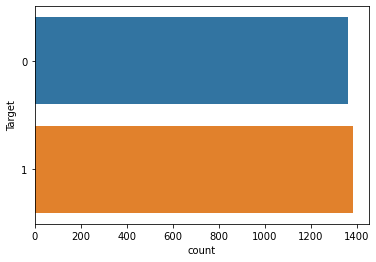

In [5]:
#Sauvegarde le Dataset au format CSV
df.to_csv("Sentiment_Analysis_Dataset")

#Affiche les colones
print(df.columns)

#Affiche le nombre de valeurs nulles par colonnes
print(df.isnull().sum())

#Affiche la répartition des labels
print(df.Target.value_counts())
sns.countplot(y="Target", data=df)


In [6]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.base import TransformerMixin
from sklearn.svm import LinearSVC 
from sklearn.pipeline import Pipeline 
import string

import spacy
from spacy.lang.en import English
from  spacy.lang.en.stop_words import STOP_WORDS

#Chargement du module Anglais
nlp = spacy.load('en_core_web_sm')
stopwords = list(STOP_WORDS)
punctuations = string.punctuation
# Création d'un parser Spacy
parser = English()

In [7]:
#Découpe les chaines de caractères en tokens + lemmatisation, renvoie un tableau de tokens
def my_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

In [8]:
#Objet servant à appliquer du pré processing sur le texte
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Mets tous les caractères en minuscule
def clean_text(text):     
    return text.strip().lower()


In [26]:
# Vectorization
vectorizer = CountVectorizer(ngram_range=(1,1)) 
classifier = LinearSVC() #On fait la classification avec l'algorithme SVM

In [10]:
#Tokenization
tfvectorizer = TfidfVectorizer()

In [30]:
# Splitting Data Set
from sklearn.model_selection import train_test_split
X = df['Message']
Y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
print(X_train.head())

Amazon  52     This phone is pretty sturdy and I've never had...
Yelp    838    I recently tried Caballero's and I have been b...
IMDB    479                         This is an excellent film.  
Yelp    965                                 But I don't like it.
        204                                Very good lunch spot.
Name: Message, dtype: object


In [31]:
#On crée un pipeline de préprocessing -> Vectorisation -> Classficiation
pipe_countvect = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

# Entraintement du model
pipe_countvect.fit(X_train,y_train)

# Predicting with a test dataset
sample_prediction = pipe_countvect.predict(X_test)

#On affiche le résultat de la prédiction
# 1 = Positive 
# 0 = Negative
for (sample,pred) in zip(X_test,sample_prediction):
    print(sample,"Prediction=>",pred)


Some applause should be given to the "prelude" however.   Prediction=> 0
The service was outshining & I definitely recommend the Halibut. Prediction=> 1
It just blew.   Prediction=> 0
I got this phone on reccomendation from a relative and I'm glad I did. Prediction=> 1
Lately they have been extremely nice and helpful on the phone. Prediction=> 1
My boyfriend and I came here for the first time on a recent trip to Vegas and could not have been more pleased with the quality of food and service. Prediction=> 1
It's close to my house, it's low-key, non-fancy, affordable prices, good food. Prediction=> 1
It's a mediocre, miserable, hollow, laughable and predictable piece of garbage.   Prediction=> 0
lightweight and works well. Prediction=> 1
No one at the table thought the food was above average or worth the wait that we had for it. Prediction=> 0
The service here is fair at best. Prediction=> 1
That company is a joke. Prediction=> 0
The meat was pretty dry, I had the sliced brisket and pull

Accuracy:  0.9994794377928162


In [36]:

print("Précision en test : ",pipe_countvect.score(X_test,y_test))
print("Fonction de perte: ",pipe_countvect.score(X_test,sample_prediction))
print("Précision en entraînement: ",pipe_countvect.score(X_train,y_train))

Précision en test :  0.808252427184466
Fonction de perte:  1.0
Précision en entraînement:  0.9994794377928162


Matrice de confusion: 

Rapport de classification sur l'ensemble de test:

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       408
           1       0.80      0.82      0.81       416

    accuracy                           0.81       824
   macro avg       0.81      0.81      0.81       824
weighted avg       0.81      0.81      0.81       824



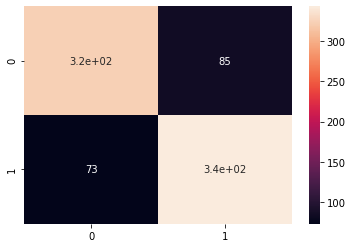

In [49]:
#Matrice de confusion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score

print("Matrice de confusion: ")
print()
cf_matrix_test = confusion_matrix(y_test, sample_prediction)
sns.heatmap(cf_matrix_test, annot=True)

print("Rapport de classification sur l'ensemble de test:")
print()
print(classification_report(y_test, sample_prediction))

In [38]:
#Prédiction d'un nouvel élément X
example = ["I do enjoy my job",
 "What a poor product!,I will have to get a new one",
 "I feel amazing!"]

pipe_countvect.predict(example)

array([0, 0, 1])